In [8]:
import pandas as pd 
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from scipy.stats import levene, ttest_ind
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split,cross_val_score, KFold, RepeatedKFold, GridSearchCV
from scipy.stats import pearsonr, ttest_ind, levene
from sklearn.ensemble import RandomForestClassifier


In [9]:
xlsx1_filePath = 'RESULT.oa.csv'
xlsx2_filePath ='RESULT.non oa.csv'
data_1 = pd.read_csv(xlsx1_filePath)
data_2 = pd.read_csv(xlsx2_filePath)

rows_1,_ = data_1.shape
rows_2,_ = data_2.shape
data = pd.concat([data_1, data_2])

In [10]:
# T检验
counts = 0
index = []
for colName in data.columns[1:]:
    if levene(data_1[colName],data_2[colName])[1] > 0.05:
        if ttest_ind(data_1[colName],data_2[colName])[1] < 0.05:
            counts += 1
            index.append(colName)
    else:
        if ttest_ind(data_1[colName],data_2[colName],equal_var = False)[1] < 0.05:
            counts += 1
            index.append(colName)
print(len(colName))

d:\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:2710: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
C:\Users\xiaof\AppData\Local\Temp\ipykernel_8516\1890022400.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  if ttest_ind(data_1[colName],data_2[colName],equal_var = False)[1] < 0.05:


8


In [11]:
if 'label' not in index:index = ['label']+index
data_1 = data_1[index]
data_2 = data_2[index]
data = pd.concat([data_1,data_2])
data = shuffle(data)  #数值打乱
data.index = range(len(data))  #打乱后重新标号
x = data[data.columns[1:]]
y = data['label']
x = x.apply(pd.to_numeric,errors='ignore')#数据类型转化为数值型
colNames = x.columns  #读取特征名
x = x.fillna(0)  #填补空白值
x = x.astype(np.float64)
x = StandardScaler().fit_transform(x) #正则化
x = pd.DataFrame(x)
x.columns = colNames
#data.to_excel("!!.xlsx",index=True)

In [12]:
alphas = np.logspace(-3,1,50)
print(alphas)
model_lassoCV = LassoCV(alphas = alphas, cv= 10, max_iter = 100000).fit(x,y)

[1.00000000e-03 1.20679264e-03 1.45634848e-03 1.75751062e-03
 2.12095089e-03 2.55954792e-03 3.08884360e-03 3.72759372e-03
 4.49843267e-03 5.42867544e-03 6.55128557e-03 7.90604321e-03
 9.54095476e-03 1.15139540e-02 1.38949549e-02 1.67683294e-02
 2.02358965e-02 2.44205309e-02 2.94705170e-02 3.55648031e-02
 4.29193426e-02 5.17947468e-02 6.25055193e-02 7.54312006e-02
 9.10298178e-02 1.09854114e-01 1.32571137e-01 1.59985872e-01
 1.93069773e-01 2.32995181e-01 2.81176870e-01 3.39322177e-01
 4.09491506e-01 4.94171336e-01 5.96362332e-01 7.19685673e-01
 8.68511374e-01 1.04811313e+00 1.26485522e+00 1.52641797e+00
 1.84206997e+00 2.22299648e+00 2.68269580e+00 3.23745754e+00
 3.90693994e+00 4.71486636e+00 5.68986603e+00 6.86648845e+00
 8.28642773e+00 1.00000000e+01]


In [13]:
print(model_lassoCV.alpha_)
coef = pd.Series(model_lassoCV.coef_, index = x.columns)
#print(coef)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)))

0.006551285568595509
Lasso picked 20 variables and eliminated the other 60


In [42]:
index = coef[coef != 0].index
x = x[index]
# print(x)
print(coef[coef != 0])

BMI                                     0.145460
SBP                                     0.101995
TG                                      0.054150
TC                                      0.038045
HbA 1c                                  0.063439
Mean                                    0.036769
Minimum                                -0.074288
VoxelNum                               -0.022967
Maximum2DDiameterSlice                  0.040343
10Percentile                            0.013496
Kurtosis                               -0.012515
Skewness                                0.003308
Correlation                             0.018791
Imc1                                   -0.028927
DependenceNonUniformity                 0.007209
GrayLevelNonUniformity                 -0.029009
SmallDependenceHighGrayLevelEmphasis   -0.015205
LargeAreaHighGrayLevelEmphasis         -0.000835
SmallAreaEmphasis                      -0.019924
ZoneEntropy                             0.044181
dtype: float64


In [15]:
# Lasso降维作图

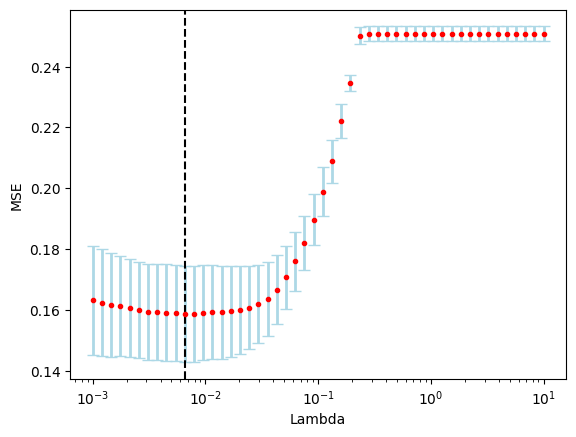

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import itertools
import time
MSEs = model_lassoCV.mse_path_
MSEs_mean = np.apply_along_axis(np.mean,1,MSEs)
MSEs_std = np.apply_along_axis(np.std,1,MSEs)
plt.figure() #dpi = 300(图片像素要求,放括号里！)
plt.errorbar(model_lassoCV.alphas_,MSEs_mean  #x,y
            ,yerr=MSEs_std  #y误差范围
            ,fmt="o"  #数据点标记
            ,ms=3  #数据点大小
            ,mfc="r"  #数据点颜色
            ,mec="r"  #数据点边缘颜色
            ,ecolor="lightblue"  #误差棒颜色
            ,elinewidth=2  #误差棒线宽度
            ,capsize=4  #误差棒边界线长度
            ,capthick=1)  #误差棒边界线厚度
plt.semilogx()  #x轴取log坐标
plt.axvline(model_lassoCV.alpha_,color= 'black',ls= '--')  #画虚线
plt.xlabel('Lambda')
plt.ylabel('MSE')
ax=plt.gca()
y_major_locator= MultipleLocator(0.02)
ax.yaxis.set_major_locator(y_major_locator)
plt.show()

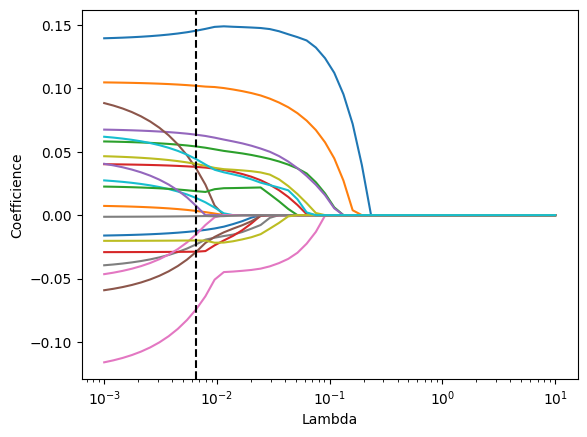

In [17]:
coefs = model_lassoCV.path(x,y,alphas = alphas, max_iter = 1000000)[1].T
plt.figure()
plt.semilogx(model_lassoCV.alphas_,coefs, '-')
plt.axvline(model_lassoCV.alpha_,color = 'black',ls='--')
plt.xlabel('Lambda')
plt.ylabel('Coefficience')
plt.show()

In [18]:
#随机森林RandomForest

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2)
model_rf = RandomForestClassifier(n_estimators=20).fit(x_train,y_train)
score_rf = model_rf.score(x_test,y_test)
print(score_rf)

0.7394366197183099


In [20]:
#支持向量机SVC

In [21]:
from sklearn.svm import SVC

In [22]:
svc_linear = SVC(kernel="linear")

In [23]:
svc_linear.fit(x_train, y_train)

SVC(kernel='linear')

In [24]:
svc_linear.coef_

array([[ 0.61736941,  0.59183503,  0.22768673,  0.17239505,  0.34883903,
         0.95287413, -1.15762324, -0.36504029,  0.20645309,  0.21617532,
        -0.01781878, -0.01634195, -0.02329978, -0.17521548,  0.2922439 ,
        -0.45241264, -0.21368433, -0.11308699, -0.15380143,  0.13556252]])

In [25]:
svc_linear.intercept_

array([-0.03043766])

In [26]:
test_predict = svc_linear.predict(x_test)
test_predict

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1], dtype=int64)

In [27]:
svc_linear.score(x_test, y_test)

0.7887323943661971

In [28]:
#效能

In [29]:
from sklearn.metrics import confusion_matrix, roc_curve,accuracy_score

In [30]:
accuracy_score(y_test, test_predict)

0.7887323943661971

In [31]:
confusion_matrix(y_test, test_predict)

array([[55, 15],
       [15, 57]], dtype=int64)

In [32]:
import seaborn as sns

<Axes: >

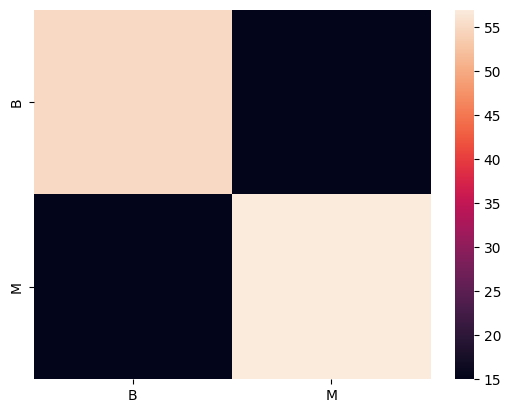

In [33]:
#热点图
sns.heatmap(confusion_matrix(y_test, test_predict),
        xticklabels=['B','M'],
        yticklabels=['B','M'])

In [34]:
y_score = svc_linear.decision_function(x_test)

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

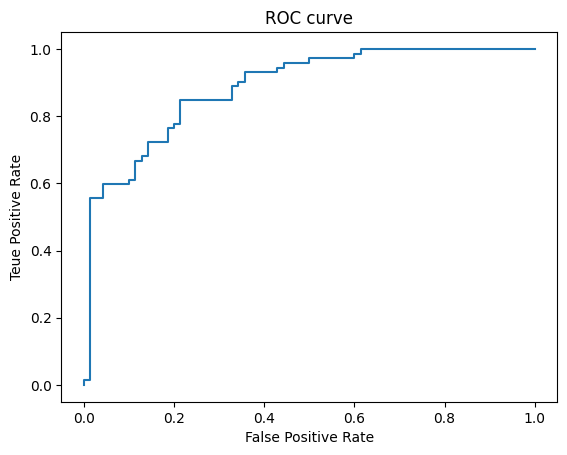

In [36]:
#ROC曲线
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('Teue Positive Rate')
plt.title('ROC curve')
plt.show()

In [37]:
#AUC曲线
from sklearn.metrics import auc

In [38]:
Cs = np.logspace(-3,2,200)
aucs_=[]
for C_ in Cs:
    svc_linear = SVC(kernel="linear",C=C_)
    svc_linear.fit(x_train, y_train)
    y_score = svc_linear.decision_function(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    auc_ = auc(fpr, tpr)
    aucs_.append(auc_)

In [39]:
aucs_

[0.834920634920635,
 0.8367063492063492,
 0.8380952380952381,
 0.8396825396825397,
 0.8400793650793651,
 0.8408730158730159,
 0.8416666666666666,
 0.844047619047619,
 0.8452380952380952,
 0.8462301587301588,
 0.8462301587301588,
 0.8478174603174603,
 0.8478174603174603,
 0.8484126984126984,
 0.8494047619047619,
 0.8501984126984128,
 0.8501984126984128,
 0.851388888888889,
 0.8525793650793652,
 0.851984126984127,
 0.8507936507936508,
 0.8517857142857144,
 0.8547619047619048,
 0.8531746031746033,
 0.8551587301587302,
 0.8549603174603174,
 0.8545634920634921,
 0.856547619047619,
 0.8577380952380952,
 0.8603174603174604,
 0.8597222222222223,
 0.860515873015873,
 0.8607142857142858,
 0.8613095238095237,
 0.8609126984126985,
 0.8611111111111112,
 0.861904761904762,
 0.8603174603174604,
 0.8625,
 0.8613095238095239,
 0.8613095238095239,
 0.8632936507936508,
 0.8642857142857143,
 0.8660714285714286,
 0.8662698412698413,
 0.8660714285714286,
 0.866468253968254,
 0.8662698412698413,
 0.865079365

In [40]:
len(aucs_)

200

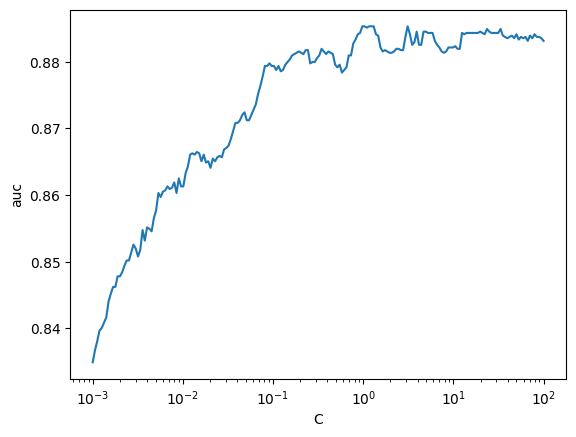

In [41]:
plt.plot(Cs, aucs_)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('auc')
plt.show()